In [11]:
#libraries
!pip install catboost
import pandas as pd




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 14.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [catboost]1/2 [catboost]


In [12]:
# 1) Load dataset
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")  
#remove spaces
train.columns = train.columns.str.strip()
test.columns  = test.columns.str.strip()
#check missing value
train.isnull().sum()
test.isnull().sum()


Employee ID                 0
Age                         0
Gender                      0
Years at Company            0
Job Role                    0
Monthly Income              0
Work-Life Balance           0
Job Satisfaction            0
Performance Rating          0
Number of Promotions        0
Overtime                    0
Distance from Home          0
Education Level             0
Marital Status              0
Number of Dependents        0
Job Level                   0
Company Size                0
Company Tenure              0
Remote Work                 0
Leadership Opportunities    0
Innovation Opportunities    0
Company Reputation          0
Employee Recognition        0
Attrition                   0
dtype: int64

In [13]:
# 2) Basic info
#for train dataset
print("Train shape:", train.shape)
print("\nTrain columns:", list(train.columns))
#for test dataset
print("\nTest shape:",  test.shape)
print("\nTest columns:",  list(test.columns))


Train shape: (59598, 24)

Train columns: ['Employee ID', 'Age', 'Gender', 'Years at Company', 'Job Role', 'Monthly Income', 'Work-Life Balance', 'Job Satisfaction', 'Performance Rating', 'Number of Promotions', 'Overtime', 'Distance from Home', 'Education Level', 'Marital Status', 'Number of Dependents', 'Job Level', 'Company Size', 'Company Tenure', 'Remote Work', 'Leadership Opportunities', 'Innovation Opportunities', 'Company Reputation', 'Employee Recognition', 'Attrition']

Test shape: (14900, 24)

Test columns: ['Employee ID', 'Age', 'Gender', 'Years at Company', 'Job Role', 'Monthly Income', 'Work-Life Balance', 'Job Satisfaction', 'Performance Rating', 'Number of Promotions', 'Overtime', 'Distance from Home', 'Education Level', 'Marital Status', 'Number of Dependents', 'Job Level', 'Company Size', 'Company Tenure', 'Remote Work', 'Leadership Opportunities', 'Innovation Opportunities', 'Company Reputation', 'Employee Recognition', 'Attrition']


In [14]:
# 3) Target mapping 
y_train = train["Attrition"].map({"Left": 1, "Stayed": 0}).astype(int)


In [15]:
# 4) Features (drop target and IDs if present)
X_train = train.drop(columns=["Attrition","Employee ID"], errors="ignore")
X_test  = test.drop(columns=["Attrition","Employee ID"], errors="ignore")  # works with or without test labels


In [16]:
# 5) Categorical columns (check the categorical col)
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
print("\nDetected categorical columns:", cat_cols)


Detected categorical columns: ['Gender', 'Job Role', 'Work-Life Balance', 'Job Satisfaction', 'Performance Rating', 'Overtime', 'Education Level', 'Marital Status', 'Job Level', 'Company Size', 'Remote Work', 'Leadership Opportunities', 'Innovation Opportunities', 'Company Reputation', 'Employee Recognition']


In [17]:
# 6) Column alignment check (train vs test)
missing_in_test  = [c for c in X_train.columns if c not in X_test.columns]
missing_in_train = [c for c in X_test.columns  if c not in X_train.columns]
print("\nColumns missing in TEST (vs train):", missing_in_test)
print("Columns missing in TRAIN (vs test):", missing_in_train)




Columns missing in TEST (vs train): []
Columns missing in TRAIN (vs test): []


In [18]:
# 7) Quick preview
print("\nPreview X_train:")
print(X_train.head(3))


Preview X_train:
   Age  Gender  Years at Company    Job Role  Monthly Income  \
0   31    Male                19   Education            5390   
1   59  Female                 4       Media            5534   
2   24  Female                10  Healthcare            8159   

  Work-Life Balance Job Satisfaction Performance Rating  Number of Promotions  \
0         Excellent           Medium            Average                     2   
1              Poor             High                Low                     3   
2              Good             High                Low                     0   

  Overtime  ...  Marital Status Number of Dependents Job Level  Company Size  \
0       No  ...         Married                    0       Mid        Medium   
1       No  ...        Divorced                    3       Mid        Medium   
2       No  ...         Married                    3       Mid        Medium   

  Company Tenure Remote Work  Leadership Opportunities  \
0             89     

_________________________________________
Build CatBoost Pools
__________________________________________

In [19]:


from catboost import Pool

#Indices of categorical columns (convert names -> positions)
cat_idx = [X_train.columns.get_loc(c) for c in cat_cols]

#Train Pool (features + labels + categorical indices)
train_pool = Pool(X_train, y_train, cat_features=cat_idx)

#Test Pool 
has_test_labels = "Attrition" in test.columns
if has_test_labels:
    y_test = test["Attrition"].map({"Left": 1, "Stayed": 0}).astype(int)
    X_test = test.drop(columns=["Attrition", "Employee ID"], errors="ignore")
    test_pool = Pool(X_test, y_test, cat_features=cat_idx)
else:
    X_test = test.drop(columns=["Employee ID"], errors="ignore")
    test_pool = Pool(X_test, cat_features=cat_idx)

print("Pools ready. Categorical indices:", cat_idx[:10], "...")


Pools ready. Categorical indices: [1, 3, 5, 6, 7, 9, 11, 12, 14, 15] ...


In [20]:
# Define the CatBoost model
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    loss_function="Logloss",   # for binary classification
    eval_metric="AUC",         # to measure prediction quality
    iterations=200,            # number of learning cycles (small baseline)
    learning_rate=0.1,         # how fast it learns
    depth=6,                   # tree depth
    random_state=42,           # for reproducibility
    verbose=50                 # print progress every 50 iterations
)

print("Model defined successfully.")


Model defined successfully.


In [21]:
#Fit the model on the training Pool
# (assumes: model, train_pool, test_pool, has_test_labels already defined)

if has_test_labels:
    model.fit(train_pool, eval_set=test_pool, use_best_model=True)
else:
    model.fit(train_pool)

print("Model training finished.")


0:	test: 0.7962302	best: 0.7962302 (0)	total: 102ms	remaining: 20.3s
50:	test: 0.8535326	best: 0.8535326 (50)	total: 1.21s	remaining: 3.53s
100:	test: 0.8545208	best: 0.8545625 (91)	total: 2.32s	remaining: 2.27s
150:	test: 0.8543984	best: 0.8545625 (91)	total: 3.46s	remaining: 1.12s
199:	test: 0.8538684	best: 0.8545625 (91)	total: 4.71s	remaining: 0us

bestTest = 0.8545625076
bestIteration = 91

Shrink model to first 92 iterations.
Model training finished.


_________________________________________
Evaluate model performance
__________________________________________

In [22]:

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

if has_test_labels:
    pred  = model.predict(test_pool)
    proba = model.predict_proba(test_pool)[:, 1]

    print("Accuracy :", round(accuracy_score(y_test, pred), 4))
    print("F1 Score :", round(f1_score(y_test, pred), 4))
    print("ROC-AUC  :", round(roc_auc_score(y_test, proba), 4))
else:
    # If test has no labels, we just create prediction probabilities
    proba = model.predict_proba(test_pool)[:, 1]
    out = test.copy()
    out["Attrition_Prob_Left"] = proba
    out.to_csv("/mnt/data/test_predictions_baseline.csv", index=False)
    print("Predictions saved to /mnt/data/test_predictions_baseline.csv")


Accuracy : 0.7629
F1 Score : 0.7492
ROC-AUC  : 0.8546


_________________________________________
Feature Importance
__________________________________________


Top 15 Most Important Features:
Job Level               21.718192
Marital Status          20.335382
Remote Work             16.728891
Work-Life Balance       11.307780
Number of Promotions     5.762266
Education Level          3.964361
Number of Dependents     3.573364
Distance from Home       3.473578
Company Reputation       3.469472
Gender                   2.879590
Years at Company         1.979236
Job Satisfaction         1.568142
Performance Rating       1.016374
Overtime                 0.904685
Age                      0.697949
dtype: float64


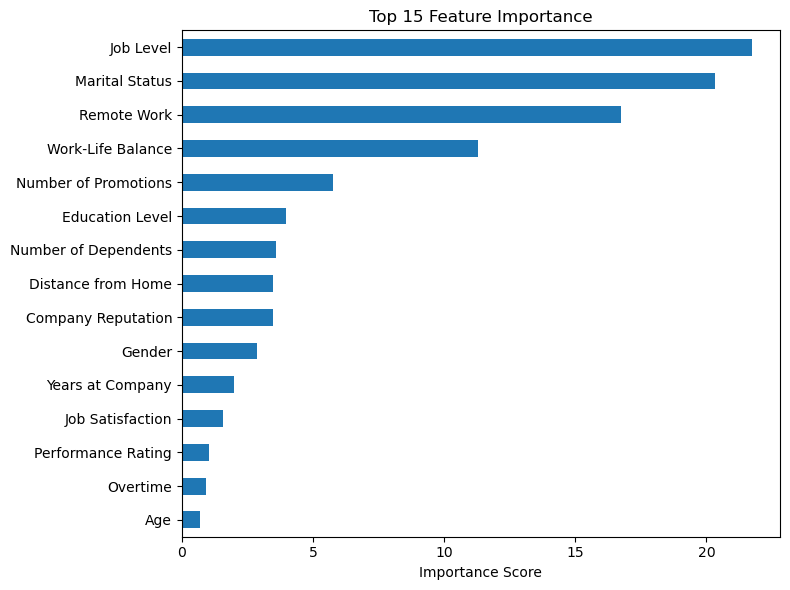

In [23]:

import matplotlib.pyplot as plt

# 1. Get feature importance scores from the model
importances = model.get_feature_importance(train_pool)

# 2. Create a pandas Series for easy display
fi = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

# 3. Print top 15 features
print("\nTop 15 Most Important Features:")
print(fi.head(15))

# 4. Optional — visualize
plt.figure(figsize=(8,6))
fi.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()
